<a href="https://colab.research.google.com/github/0-lingual/Deepfake-Detection-CNN/blob/main/gan_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


manualSeed = 999


random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

In [ ]:

dataroot = "/kaggle/input/deepfake-and-real-images"

workers = 2

batch_size = 128

image_size = 64

nc = 3

nz = 100

ngf = 256

ndf = 64

num_epochs = 1

lr = 0.0002

beta1 = 0.6

ngpu = 2

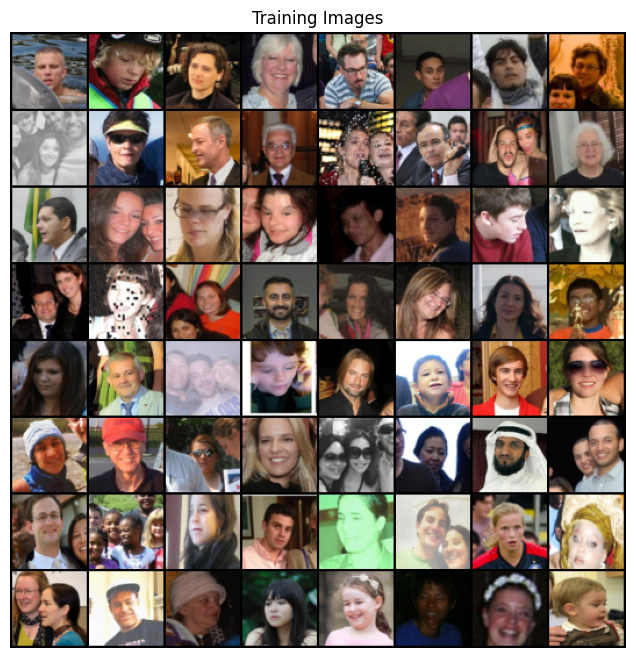

In [ ]:
# 데이터셋을 ImageFolder로 불러오고, 다양한 변환을 적용
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),  # 이미지 크기 조정
                               transforms.CenterCrop(image_size),  # 이미지 중앙 자르기
                               transforms.ToTensor(),  # 이미지를 Tensor로 변환
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 이미지 정규화
                           ]))

# DataLoader를 사용하여 데이터셋을 배치로 불러오고, 셔플링 및 워커 수 설정
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 사용 가능한 디바이스 설정 (CUDA가 가능하고 GPU 수가 0보다 큰 경우 GPU 사용)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 데이터 로더에서 첫 번째 배치를 가져옴
real_batch = next(iter(dataloader))

# 이미지 시각화를 위한 설정
plt.figure(figsize=(8,8))
plt.axis("off")  # 축을 끔
plt.title("Training Images")  # 제목 설정
# 이미지를 그리드 형식으로 표시, GPU에서 CPU로 데이터를 이동시킨 후 시각화
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    # Conv 레이어의 가중치를 정규 분포로 초기화
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    # BatchNorm 레이어의 가중치와 편향을 초기화
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
import torch
import torch.nn as nn

# Discriminator 클래스 정의
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # Conv 레이어
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(128),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(256),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(512),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # 마지막 Conv 레이어
            nn.Sigmoid()  # 출력 활성화 함수
        )

    def forward(self, input):
        return self.main(input)

# 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    # Conv 레이어의 가중치를 정규 분포로 초기화
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    # BatchNorm 레이어의 가중치와 편향을 초기화
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 디바이스 및 GPU 수 초기화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ngpu = torch.cuda.device_count()  # 사용 가능한 GPU 수 설정

# Discriminator 초기화
netD = Discriminator(ngpu).to(device)

# 여러 개의 GPU를 사용할 수 있는 경우 DataParallel 사용
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 가중치 초기화 함수 적용
netD.apply(weights_init)

# 네트워크 아키텍처 출력
print(netD)


DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력은 Z, convolution을 통해 들어감
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # Transposed Conv 레이어
            nn.BatchNorm2d(ngf * 8),  # 배치 정규화
            nn.ReLU(True),  # 활성화 함수
            # 상태 크기: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # Transposed Conv 레이어
            nn.BatchNorm2d(ngf * 4),  # 배치 정규화
            nn.ReLU(True),  # 활성화 함수
            # 상태 크기: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # Transposed Conv 레이어
            nn.BatchNorm2d(ngf * 2),  # 배치 정규화
            nn.ReLU(True),  # 활성화 함수
            # 상태 크기: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # Transposed Conv 레이어
            nn.BatchNorm2d(ngf),  # 배치 정규화
            nn.ReLU(True),  # 활성화 함수
            # 상태 크기: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 마지막 Transposed Conv 레이어
            nn.Tanh()  # 출력 활성화 함수
            # 상태 크기: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Generator 초기화
netG = Generator(ngpu).to(device)

# 여러 개의 GPU를 사용할 수 있는 경우 DataParallel 사용
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 가중치 초기화 함수 적용
netG.apply(weights_init)

# Generator 네트워크 아키텍처 출력
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(256, 3, kernel_size=(4, 4), str

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 크기: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # Conv 레이어
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            # 상태 크기: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(ndf * 2),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            # 상태 크기: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(ndf * 4),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            # 상태 크기: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Conv 레이어
            nn.BatchNorm2d(ndf * 8),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수
            # 상태 크기: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 마지막 Conv 레이어
            nn.Sigmoid()  # 출력 활성화 함수
        )

    def forward(self, input):
        return self.main(input)


In [ ]:

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

[0/1][0/1487]	Loss_D: 1.6956	Loss_G: 6.5481	D(x): 0.6711	D(G(z)): 0.6465 / 0.0022
[0/1][50/1487]	Loss_D: 0.4965	Loss_G: 6.1420	D(x): 0.8073	D(G(z)): 0.0922 / 0.0024
[0/1][100/1487]	Loss_D: 1.0250	Loss_G: 11.4690	D(x): 0.5971	D(G(z)): 0.0060 / 0.0000
[0/1][150/1487]	Loss_D: 1.3709	Loss_G: 3.7810	D(x): 0.6242	D(G(z)): 0.3379 / 0.0345
[0/1][200/1487]	Loss_D: 1.6994	Loss_G: 2.1868	D(x): 0.5637	D(G(z)): 0.5008 / 0.1593
[0/1][250/1487]	Loss_D: 1.4387	Loss_G: 1.4845	D(x): 0.5058	D(G(z)): 0.3943 / 0.2784
[0/1][300/1487]	Loss_D: 1.1376	Loss_G: 1.6376	D(x): 0.5393	D(G(z)): 0.3446 / 0.2142
[0/1][350/1487]	Loss_D: 0.7713	Loss_G: 2.6171	D(x): 0.6803	D(G(z)): 0.2348 / 0.0865
[0/1][400/1487]	Loss_D: 0.8216	Loss_G: 2.4067	D(x): 0.6728	D(G(z)): 0.2329 / 0.1273
[0/1][450/1487]	Loss_D: 1.2773	Loss_G: 1.4715	D(x): 0.5249	D(G(z)): 0.3837 / 0.2638
[0/1][500/1487]	Loss_D: 1.2465	Loss_G: 1.9425	D(x): 0.4940	D(G(z)): 0.3208 / 0.1926
[0/1][550/1487]	Loss_D: 1.4276	Loss_G: 1.4568	D(x): 0.5117	D(G(z)): 0.3876 / 0

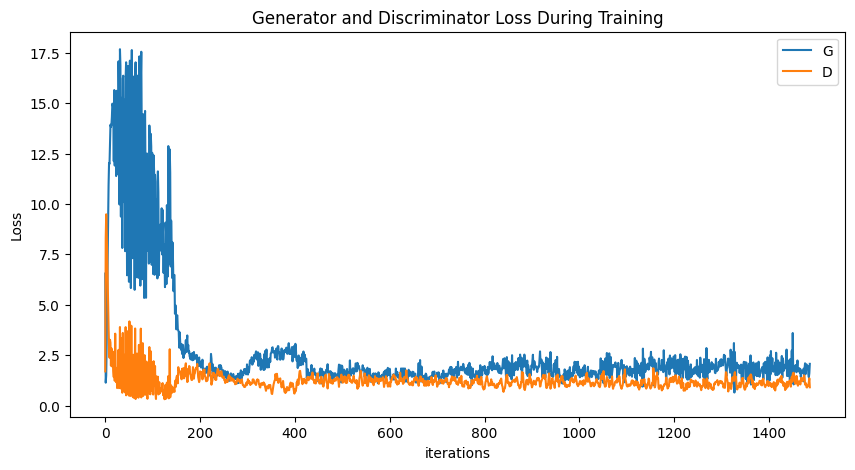

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Discriminator의 기울기 초기화 및 실제 배치 처리
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 배치 생성 및 처리
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator 업데이트
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 손실 값 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 손실 값 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 생성된 이미지 저장
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# 손실 값 시각화
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

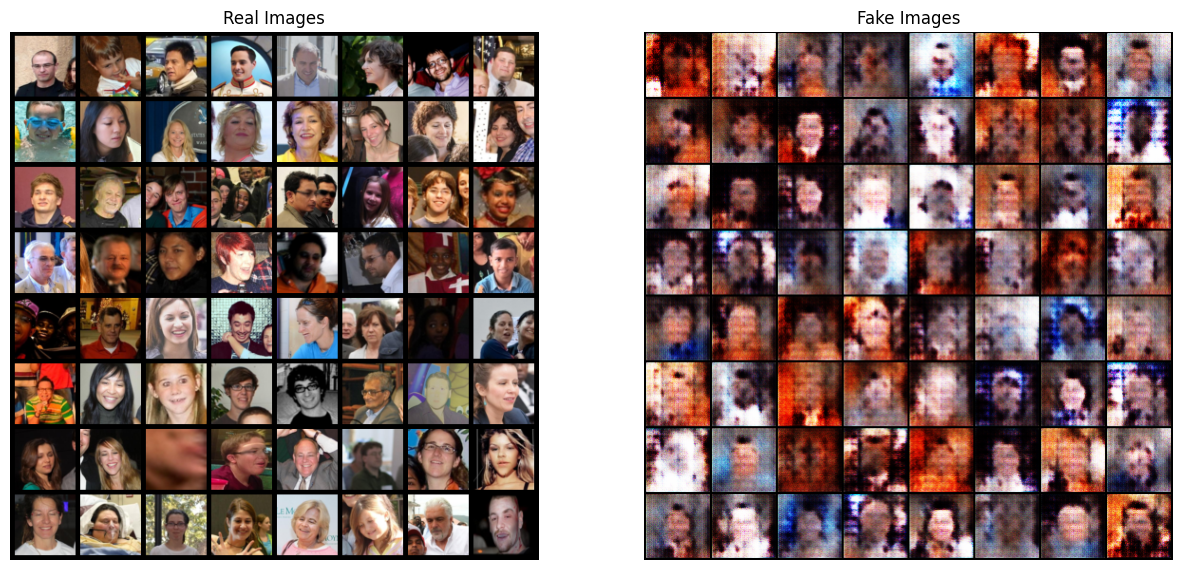

In [ ]:
real_batch = next(iter(dataloader))

# 실제 이미지를 플로팅
plt.figure(figsize=(15,15))

# 실제 이미지
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()


In [ ]:
num_epochs = 1

lr = 0.0001

beta1 = 0.9

[0/1][0/1487]	Loss_D: 1.1516	Loss_G: 1.7427	D(x): 0.5550	D(G(z)): 0.3325 / 0.2241
[0/1][50/1487]	Loss_D: 1.0624	Loss_G: 1.9154	D(x): 0.7077	D(G(z)): 0.4468 / 0.1870
[0/1][100/1487]	Loss_D: 1.5799	Loss_G: 0.9126	D(x): 0.2947	D(G(z)): 0.1034 / 0.4502
[0/1][150/1487]	Loss_D: 1.0590	Loss_G: 1.7144	D(x): 0.6871	D(G(z)): 0.4305 / 0.2235
[0/1][200/1487]	Loss_D: 0.9435	Loss_G: 1.6616	D(x): 0.5723	D(G(z)): 0.2192 / 0.2380
[0/1][250/1487]	Loss_D: 1.2251	Loss_G: 1.6465	D(x): 0.5224	D(G(z)): 0.3246 / 0.2342
[0/1][300/1487]	Loss_D: 1.2024	Loss_G: 2.0472	D(x): 0.6977	D(G(z)): 0.5030 / 0.1715
[0/1][350/1487]	Loss_D: 1.2643	Loss_G: 3.2741	D(x): 0.6513	D(G(z)): 0.4908 / 0.0562
[0/1][400/1487]	Loss_D: 1.4159	Loss_G: 2.6717	D(x): 0.7418	D(G(z)): 0.5933 / 0.0967
[0/1][450/1487]	Loss_D: 1.4203	Loss_G: 1.0372	D(x): 0.4114	D(G(z)): 0.2759 / 0.4010
[0/1][500/1487]	Loss_D: 1.4958	Loss_G: 1.4473	D(x): 0.4540	D(G(z)): 0.3309 / 0.2835
[0/1][550/1487]	Loss_D: 1.2063	Loss_G: 2.1825	D(x): 0.6728	D(G(z)): 0.4896 / 0.

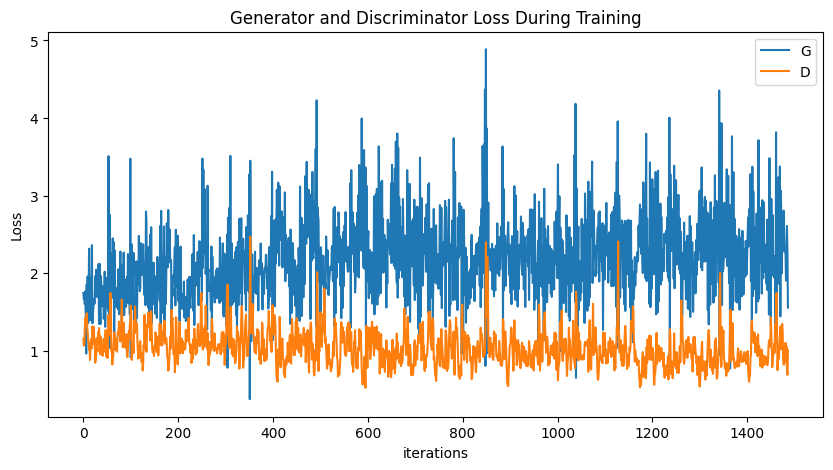

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Discriminator의 기울기 초기화 및 실제 배치 처리
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 배치 생성 및 처리
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator 업데이트
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 손실 값 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 손실 값 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 생성된 이미지 저장
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# 손실 값 시각화
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


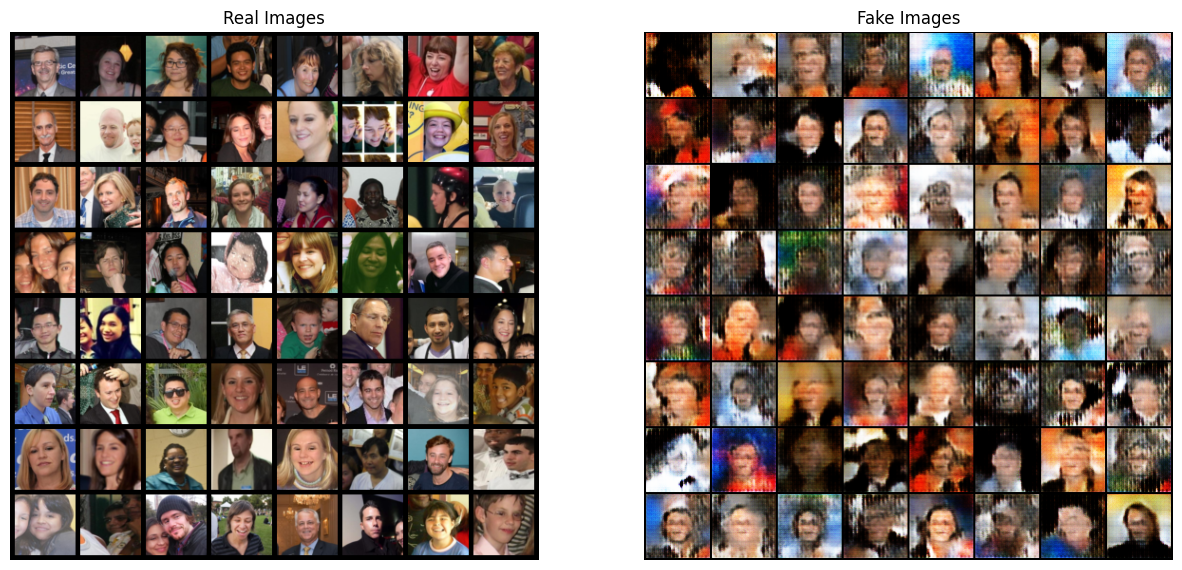

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()